<a href="https://colab.research.google.com/github/Swastiii-ai/shopper-spectrum/blob/main/Shopper_Spectrum_Segmentations_and_Recommendations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SHOPPER SPECTRUM : CUSTOMER SEGMENTATION AND PRODUCT RECOMMENDATIONS**

DOMAIN : E-COMMERCE AND RETAIL ANALYTICS

PROBLEM STATEMENT

The global e-commerce industry generates vast amounts of transaction data daily, offering valuable insights into customer purchasing behaviors. Analyzing this data is essential for identifying meaningful customer segments and recommending relevant products to enhance customer experience and drive business growth. This project aims to examine transaction data from an online retail business to uncover patterns in customer purchase behavior, segment customers based on Recency, Frequency, and Monetary (RFM) analysis, and develop a product recommendation system using collaborative filtering techniques.

REAL-TIME BUSINESS USE CASES

Customer Segmentation for Targeted Marketing Campaigns


Personalized Product Recommendations on E-Commerce Platforms


Identifying At-Risk Customers for Retention Programs


Dynamic Pricing Strategies Based on Purchase Behavior


Inventory Management and Stock Optimization Based on Customer Demand Patterns


PROBLEM TYPE

Unsupervised Machine Learning – Clustering
Collaborative Filtering – Recommendation System


**Step 1 : Data collection and understanding**

Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
!pip install streamlit

Load the dataset

In [ ]:
df = pd.read_csv("/content/online_retail.csv")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


Basic overview of the dataset

In [ ]:
print("Dataset shape:", df.shape)
df.info()
df.isnull().sum()
print("\nUnique Countries:", df['Country'].nunique())

Dataset shape: (176140, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176140 entries, 0 to 176139
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    176140 non-null  object 
 1   StockCode    176140 non-null  object 
 2   Description  175400 non-null  object 
 3   Quantity     176140 non-null  int64  
 4   InvoiceDate  176140 non-null  object 
 5   UnitPrice    176140 non-null  float64
 6   CustomerID   123647 non-null  float64
 7   Country      176139 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.8+ MB

Unique Countries: 36


**Step 2 : Data Preprocessing**

Remove rows with missing CustomerID

In [ ]:
df = df.dropna(subset=['CustomerID'])
print("After removing missing CustomerID rows:", df.shape)

After removing missing CustomerID rows: (123647, 8)


Exclude cancelled invoices (InvoiceNo starting with 'C')

In [ ]:
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("After removing cancelled orders:", df.shape)

After removing cancelled orders: (120575, 8)


Remove negative or zero quantities and prices

In [ ]:
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
print("After removing non-positive Quantity/UnitPrice:", df.shape)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df.head()

After removing non-positive Quantity/UnitPrice: (120564, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


**Step 3 : Exploratory Data Analysis (EDA)**

1.Top 10 countries by no.of transactions

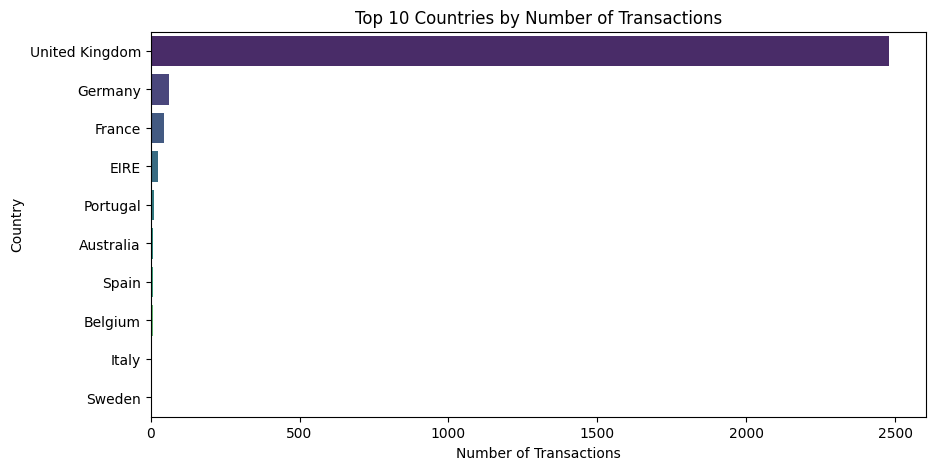

In [ ]:
country_orders = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=country_orders.values, y=country_orders.index, palette="viridis")
plt.title("Top 10 Countries by Number of Transactions")
plt.xlabel("Number of Transactions")
plt.ylabel("Country")
plt.show()

2.Top 10 selling products

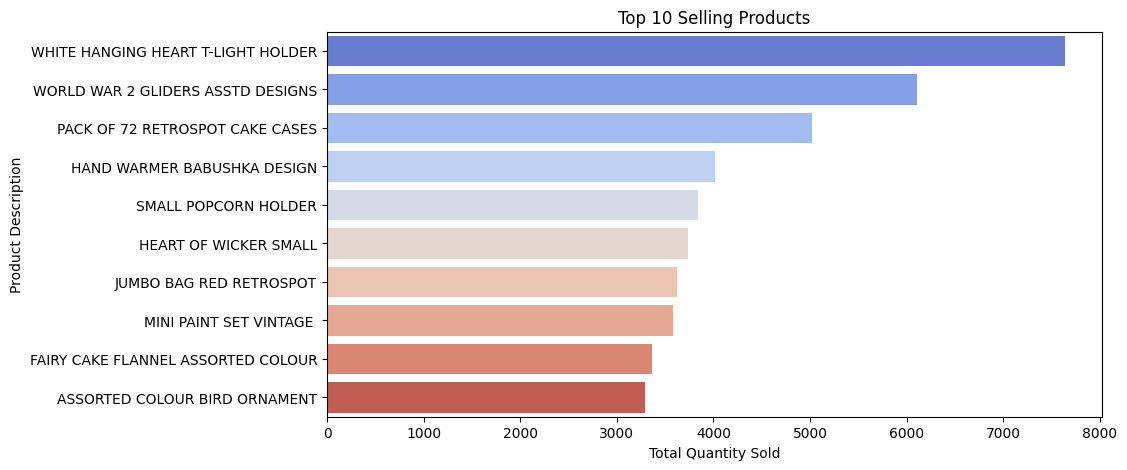

In [ ]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index, palette="coolwarm")
plt.title("Top 10 Selling Products")
plt.xlabel("Total Quantity Sold")
plt.ylabel("Product Description")
plt.show()

3.Sales trend over time

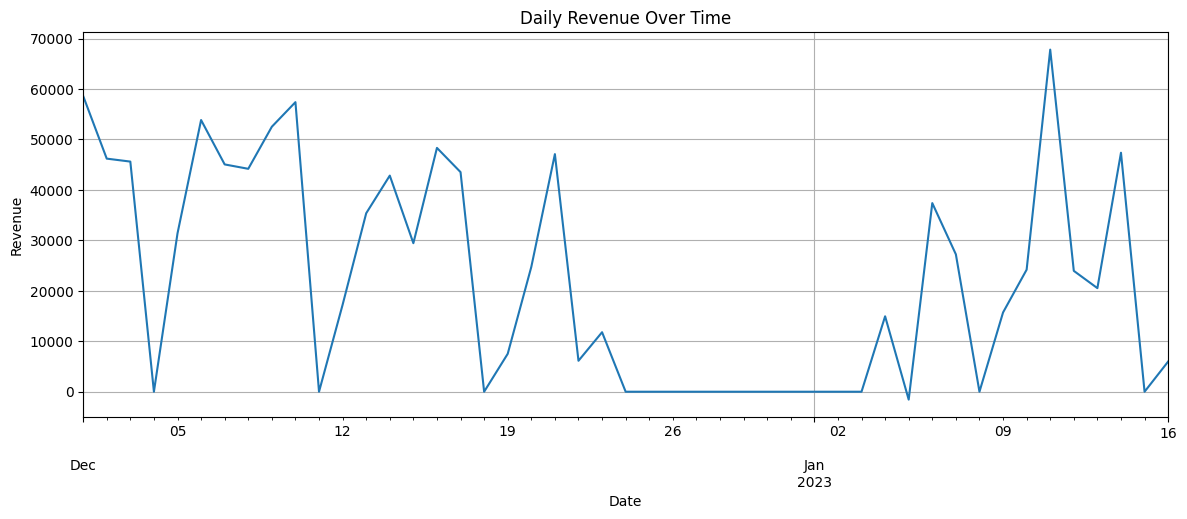

In [ ]:
df = df[pd.to_datetime(df['InvoiceDate'], errors='coerce').notna()]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
daily_revenue = df.set_index('InvoiceDate').resample('D')['TotalPrice'].sum()

plt.figure(figsize=(14,5))
daily_revenue.plot()
plt.title("Daily Revenue Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()

4.Distribution of monetary value per customer

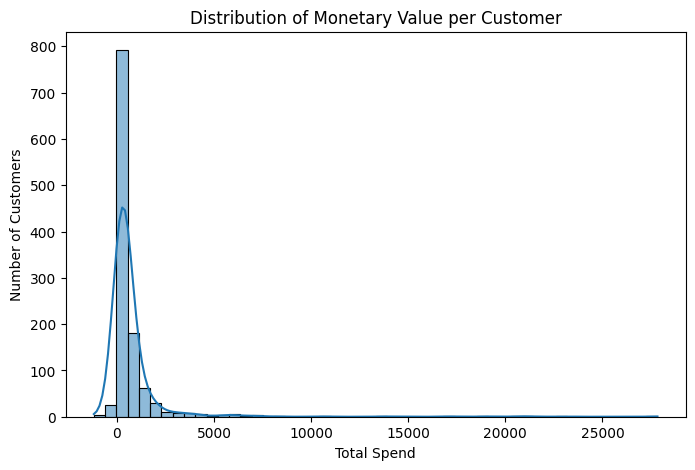

In [ ]:
customer_monetary = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(8,5))
sns.histplot(customer_monetary, bins=50, kde=True)
plt.title("Distribution of Monetary Value per Customer")
plt.xlabel("Total Spend")
plt.ylabel("Number of Customers")
plt.show()


**Step 4 : RFM Feature Engineering and Clustering**

1. Compute RFM metrics

In [ ]:
latest_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,41,1,711.79
1,12348.0,31,1,892.80
2,12359.0,5,1,547.50
3,12370.0,31,2,1868.02
4,12377.0,28,1,1001.52


2. Normalise RFM features

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

3. Elbow method to choose K

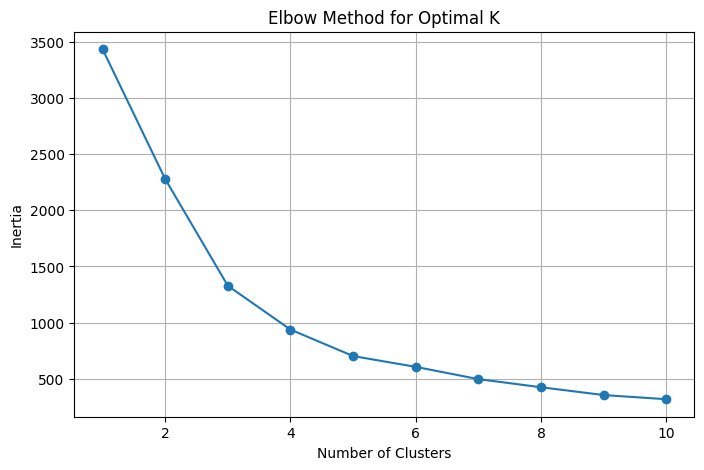

In [ ]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()

4. Run KMeans clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

5. Interpret cluster profiles (RFM Averages)

In [ ]:
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'}).round(2)

cluster_summary

,Recency,Frequency,Monetary,Count
Cluster,,,,
0,37.13,1.48,368.21,717
1,7.47,2.43,863.32,411
2,9.75,6.12,19131.12,8
3,8.88,20.88,5366.34,8


6. Assign segment labels

In [ ]:
segment_map = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}
rfm['Segment'] = rfm['Cluster'].map(segment_map)
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12347.0,41,1,711.79,0,High-Value
1,12348.0,31,1,892.80,0,High-Value
2,12359.0,5,1,547.50,1,Regular
3,12370.0,31,2,1868.02,0,High-Value
4,12377.0,28,1,1001.52,0,High-Value


7. Visualise clusters (2D scatter plots)

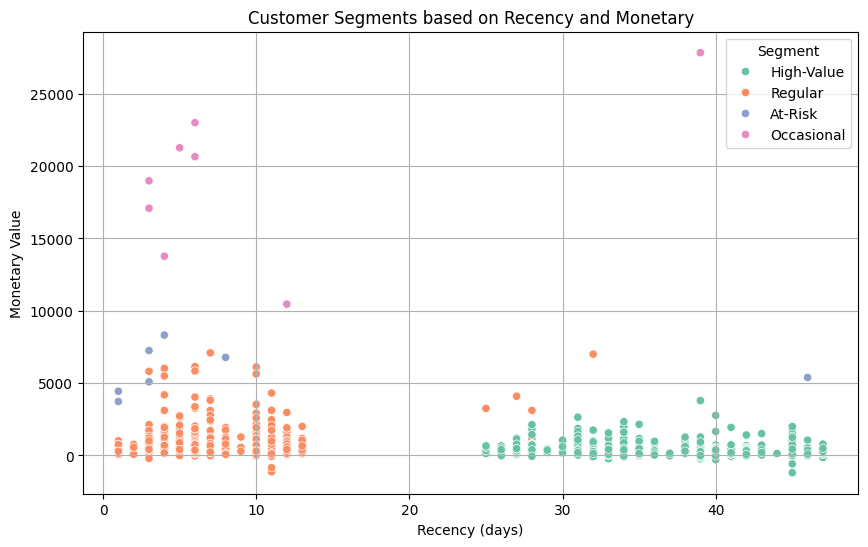

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='Set2')
plt.title("Customer Segments based on Recency and Monetary")
plt.xlabel("Recency (days)")
plt.ylabel("Monetary Value")
plt.grid(True)
plt.show()

8. Save the KMeans model

In [ ]:
import pickle
with open("rfm_kmeans_model.pkl", "wb") as f:
    pickle.dump((kmeans, scaler), f)

**Step 5 : Product Recommendation system**

1. Create a customer-product matrix

In [ ]:
pivot = df.pivot_table(index='CustomerID', columns='Description', values='Quantity', aggfunc='sum')
pivot.fillna(0, inplace=True)
pivot.shape

(1144, 2566)

2. Compute cosine similarity between products

In [ ]:
product_matrix = pivot.T
similarity_matrix = cosine_similarity(product_matrix)
product_similarity_df = pd.DataFrame(similarity_matrix, index=product_matrix.index, columns=product_matrix.index)
product_similarity_df.iloc[:5, :5]

Description,4 PURPLE FLOCK DINNER CANDLES,OVAL WALL MIRROR DIAMANTE,SET 2 TEA TOWELS I LOVE LONDON,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS
Description,,,,,
4 PURPLE FLOCK DINNER CANDLES,1.0,0.000000,0.000000,0.0,0.0
OVAL WALL MIRROR DIAMANTE,0.0,1.000000,0.002581,0.0,0.0
SET 2 TEA TOWELS I LOVE LONDON,0.0,0.002581,1.000000,0.0,0.0
10 COLOUR SPACEBOY PEN,0.0,0.000000,0.000000,1.0,0.0
12 COLOURED PARTY BALLOONS,0.0,0.000000,0.000000,0.0,1.0


3. Recommendation function

In [ ]:
def get_similar_products(product_name, top_n=5):
    if product_name not in product_similarity_df.index:
        return ["Product not found."]
    similar_scores = product_similarity_df[product_name].sort_values(ascending=False)[1:top_n+1]
    return list(similar_scores.index)

Example usage

In [ ]:
get_similar_products("WHITE HANGING HEART T-LIGHT HOLDER")

['GIN + TONIC DIET METAL SIGN',
 'DOORMAT FAIRY CAKE',
 'FAIRY CAKE FLANNEL ASSORTED COLOUR',
 'TEA TIME TEA TOWELS ',
 'RED HANGING HEART T-LIGHT HOLDER']

4. Save the similarity matrix

In [ ]:
with open("product_similarity_matrix.pkl", "wb") as f:
    pickle.dump(product_similarity_df, f)

**Step 6 : Streamlit app**

In [ ]:
import streamlit as st
import pickle
import numpy as np
with open("rfm_kmeans_model.pkl", "rb") as f:
    kmeans, scaler = pickle.load(f)
with open("product_similarity_matrix.pkl", "rb") as f:
    similarity_df = pickle.load(f)

segment_map = {
    0: 'High-Value',
    1: 'Regular',
    2: 'Occasional',
    3: 'At-Risk'
}

st.title("🛍️ Shopper Spectrum: Segmentation & Recommendations")

st.sidebar.header("Select Module")
module = st.sidebar.radio("Choose one", ["🎯 Product Recommendation", "🔍 Customer Segmentation"])

# 🎯 1. Product Recommendation Module

if module == "🎯 Product Recommendation":
    st.header("🎯 Product Recommendation")

    product_list = similarity_df.index.tolist()
    product_input = st.selectbox("Choose a product:", product_list)

    if st.button("Get Recommendations"):
        if product_input not in similarity_df.index:
            st.error("Product not found.")
        else:
            similar_items = similarity_df[product_input].sort_values(ascending=False)[1:6].index.tolist()
            st.success("Recommended Products:")
            for i, item in enumerate(similar_items, 1):
                st.write(f"{i}. {item}")

# 🔍 2. Customer Segmentation Module

elif module == "🔍 Customer Segmentation":
    st.header("🔍 Customer Segmentation")

    recency = st.number_input("Recency (days since last purchase)", min_value=0, max_value=1000, step=1)
    frequency = st.number_input("Frequency (number of purchases)", min_value=0, step=1)
    monetary = st.number_input("Monetary (total spend)", min_value=0.0, step=10.0, format="%.2f")

    if st.button("Predict Cluster"):
        user_input = scaler.transform([[recency, frequency, monetary]])
        cluster = kmeans.predict(user_input)[0]
        segment = segment_map.get(cluster, "Unknown")
        st.success(f"Customer Segment: **{segment}**")

2025-08-03 11:46:11.180 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.185 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.188 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.190 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.192 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.193 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 11:46:11.195 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

NGROK Tunnel

In [ ]:
from google.colab import userdata
import os

os.environ["NGROK_AUTH_TOKEN"] = userdata.get("NGROK_AUTH_TOKEN")

In [ ]:
from pyngrok import ngrok
from google.colab import userdata
NGROK_AUTH_TOKEN = userdata.get("NGROK_AUTH_TOKEN")
ngrok.set_auth_token(NGROK_AUTH_TOKEN)
public_url = ngrok.connect(8501)
print("Streamlit app is live at:", public_url)

Streamlit app is live at: NgrokTunnel: "https://a710131eae6f.ngrok-free.app" -> "http://localhost:8501"
